<a href="https://colab.research.google.com/github/evilsizord/mscs-data-mining-project/blob/main/Data_Mining_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Review Classification
Final Project \
CSE 5334 - Data Mining \
Daniel Evilsizor \
November 13, 2022

In [1]:
# Get Data from Kaggle.com

# NOTE: Requires you to have a Kaggle.com account. From your account you can generate an API key.
# It will be provided in kaggle.json. Upload the JSON file to this project BEFORE RUNNING.

# src: https://www.kaggle.com/general/74235

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download vivekgediya/ecommerce-product-review-data
! mkdir dataset
! unzip ecommerce-product-review-data.zip -d dataset

 94% 8.00M/8.55M [00:00<00:00, 82.6MB/s]
100% 8.55M/8.55M [00:00<00:00, 86.7MB/s]
Archive:  ecommerce-product-review-data.zip
  inflating: dataset/Automotive_5.json  
  inflating: dataset/Flipkart_Reviews - Electronics.csv  
  inflating: dataset/Product Review Data.csv  
  inflating: dataset/Product Review Large Data.csv  
  inflating: dataset/electronics_reviews_uniq.json  


In [30]:
# load all necessary libraries
import os
from collections import defaultdict
import pandas
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, losses
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

nltk.download('punkt')  # needed for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
class MyTokenizer:
  def __init__(self):
    self.stemmer = SnowballStemmer("english")
    self.stop_words = set(stopwords.words('english'))

  def tokenize(self, doc):
    # strip punctuation, it's not needed
    # ref: https://stackoverflow.com/questions/3411771/best-way-to-replace-multiple-characters-in-a-string
    chars = "/*[]()>#+,.!;:?"
    for c in chars:
        doc = doc.replace(c, " ")
    tokens = word_tokenize(doc)
    # remove stop words
    # ref: https://stackoverflow.com/questions/15547409/how-to-get-rid-of-punctuation-using-nltk-tokenizer
    # Also, convert to a set so we only get unique words per row (no duplicates)
    words = set()
    for tok in tokens:
      word = self.stemmer.stem(tok)
      if not word.lower() in self.stop_words:
        words.add(word)
    return words


class NaiveBayesClassifier:

  def __init__(self, vocab, classes, tokenizer):
    self.class_counts = self.new_default_zero_dict()
    self.class_probs = self.new_default_zero_dict()     # p(class)
    self.classes = classes                              # [class1, class2, ..]
    self.word_probs = self.new_default_zero_dict()      # p(w|class)
    #self.post_probs = {}      # p(class|w)
    self.word_counts = self.new_default_zero_dict()     # {total:n1, class1: n2, ... }
    self.tokenizer = tokenizer
    self.use_smoothing = False

    for word in vocab:
      self.word_counts[word] = self.new_default_zero_dict()

  def __default_zero__():
    return 0
  
  def new_default_zero_dict(self):
    return defaultdict(lambda: 0)

  def count_frequencies(self, dataset):
    for row in dataset:
      words = self.tokenizer.tokenize(row['sentence'])
      y = row['class']
      self.class_counts[y] += 1

      # count overall word frequency, and frequency per class (label)
      for word in words:
        self.word_counts[word]['total'] += 1
        self.word_counts[word][y] += 1

    for c in self.classes:
      self.class_probs[c] = self.class_counts[c] / len(dataset)

  # calculate probs from a training dataset
  def train(self, dataset):
    self.count_frequencies(dataset)

    # Calculate	Conditional probability of all words based on category
    num_words = len(self.word_counts)
    for word in self.word_counts:
      for c in self.classes:
        #	P(word|class)  = # of documents in category containing word / num of all documents in that category
        word_cat_freq = self.word_counts[word][c]
        key = word + '__' + str(c)
        if self.use_smoothing:
          self.word_probs[key] = (word_cat_freq + 1) / (self.class_counts[c] + num_words)
        else:
          self.word_probs[key] = word_cat_freq / self.class_counts[c]

  # return most likely class for each document
  def predict(self, dataset):
    # foreach document:
    #  foreach class, calculate p(class|tokens) = p(tokens|class)*p(class) / p(tokens)
    # (since p(tokens) is effectively a constant scaling factor when comparing these, we can ignore it)
    Y_hat = []
    for row in dataset:
      words = self.tokenizer.tokenize(row['sentence'])
      probs = {}
      for c in self.classes:
        p = self.class_probs[c]
        for w in words:
          p *= self.word_probs[(w + '__' + str(c))]
        probs[c] = p
      
      # predicted class is the one with max probability
      Y_hat.append(max(probs, key=probs.get))
      
    return Y_hat

  def get_predictors(self, arg_class, vocab_probs):
    predictors = {}
    for word in self.word_counts:
      # p(class|word) = p(word|class)*p(class)/p(word)
      if word in vocab_probs:
        predictors[word] = self.word_probs[word + '__' + str(arg_class)] * self.class_probs[arg_class] / vocab_probs[word]
      else:
        predictors[word] = 0
    return predictors



In [32]:
# Load the data
infile1 = pandas.read_json('dataset/Automotive_5.json', lines=True)
infile2 = pandas.read_json('dataset/electronics_reviews_uniq.json', orient='records')
infile3 = pandas.read_csv('dataset/Flipkart_Reviews - Electronics.csv')

# Standardize column headings to: (class, review, review_title)
infile1.rename(columns={'overall': 'class', 'reviewText': 'review', 'summary': 'review_title'}, inplace=True)
infile2.rename(columns={'description': 'review', 'rating': 'class'}, inplace=True)
infile3.rename(columns={'summary': 'review_title', 'rating': 'class'}, inplace=True)

def format_data(df):
  # convert all rating values to ints (1-5)
  # todo: check for any invalid rating values
  df = df.astype({"class": int})

  # Combine the review with the summary (review title)
  # ref: https://sparkbyexamples.com/pandas/pandas-combine-two-columns-of-text-in-dataframe/
  df['sentence'] = df['review_title'] + " " + df['review']

  # Remove unnecessary data columns (we just want [sentence, class])
  return df[['sentence', 'class']]

df1 = format_data(infile1)
df2 = format_data(infile2)
df3 = format_data(infile3)

# preview each input file to ensure data looks correct
print('File1 has', len(df1), 'rows')
print(df1.head(5))
print('File2 has', len(df2), 'rows')
print(df2.head(5))
print('File3 has', len(df3), 'rows')
print(df3.head(5))


File1 has 20473 rows
                                            sentence  class
0  Work Well - Should Have Bought Longer Ones I n...      5
1  Okay long cables These long cables work fine f...      4
2  Looks and feels heavy Duty Can't comment much ...      5
3  Excellent choice for Jumper Cables!!! I absolu...      5
4  Excellent, High Quality Starter Cables I purch...      5
File2 has 15166 rows
                                            sentence  class
0  Super! 1) Camera quality : Awesome ... it gene...      5
1  Terrific purchase Awesome mobile , I got it wi...      5
2  Delightful Honor 10 lite :Pros :-1) Cameras ar...      4
3  Brilliant Superb camera, beautiful and slim de...      5
4  Must buy! good and best mobil honor is best co...      5
File3 has 9374 rows
                                            sentence  class
0  Terrific purchase 1-more flexible2-bass is ver...      5
1  Terrific purchase Super sound and good looking...      5
2  Super! Very much satisfied with the

In [33]:
# merge the data
all_data = pandas.concat([df1, df2, df3])

# how many rows?
print(len(all_data), 'total rows loaded')

# throw out any empty reviews (see https://stackoverflow.com/a/56708633)
all_data['sentence'].replace('', np.nan, inplace=True)
all_data.dropna(subset=['sentence'], inplace=True)
print(len(all_data), 'rows after removing empty reviews')

# Convert to dict for easier processing later
all_data = all_data.to_dict('records')

classes = [1,2,3,4,5]

split1 = int(.8*len(all_data))
split2 = int(.9*len(all_data))
traindata = all_data[:split1]
devdata = all_data[split1:split2]
testdata = all_data[split2:]

print(len(traindata), 'training,', len(devdata), 'dev,', len(testdata), 'test rows loaded')

X_train = [row.get('sentence') for row in traindata]
y_train = [row.get('class') for row in traindata]

X_val = [row.get('sentence') for row in devdata]
y_val = [row.get('class') for row in devdata]

X_test = [row.get('sentence') for row in testdata]
y_test = [row.get('class') for row in testdata]


45013 total rows loaded
45013 rows after removing empty reviews
36010 training, 4501 dev, 4502 test rows loaded


In [34]:
# Generate vocabulary
vocab = set()
tokenizer = MyTokenizer()

for row in all_data:
  row['tokens'] = tokenizer.tokenize(row['sentence'])
  for tok in row['tokens']:
    vocab.add(tok)

# preview
print('Found', len(vocab), 'words in vocabulary')
for id,val in enumerate(vocab):
  if id < 25:
    print(val + ", ")


Found 31120 words in vocabulary
warrantyupd, 
pursu, 
soun, 
crappi, 
needle-nos, 
non-incandesc, 
rollback, 
rangeyou, 
-sound, 
poduct, 
vortex, 
jod, 
pre-mold, 
headlin, 
00272-sllc2, 
-best, 
maalibu, 
non-obd-ii, 
clayblock, 
betweenbear, 
rewiew, 
looki, 
venthos, 
previousali, 
dy, 


In [35]:
# Train the model
nbc = NaiveBayesClassifier(vocab, classes, tokenizer)
nbc.train(traindata)

In [36]:
# Calculate probability of occurrance of each word
vocab_probs = {}
for word in vocab:
  if (nbc.word_counts[word]['total'] > 0):    # if freq == 0 that means it did not appear in the training data
    vocab_probs[word] = nbc.word_counts[word]['total'] / len(traindata)

# preview: words with highest probability
print('Top 5: words with highest probability')
for w in sorted(vocab_probs, key=vocab_probs.get, reverse=True)[:8]:
  print(w, vocab_probs[w])

# preview: words with lowest probability
print("\n",'Bottom 5: words with lowest probability')
for w in sorted(vocab_probs, key=vocab_probs.get)[:8]:
  print(w, vocab_probs[w])

Top 5: words with highest probability
good 0.33832268814218275
use 0.2915301305193002
product 0.260483199111358
work 0.22826992502082755
great 0.21727297972785337
veri 0.21627325742849207
n't 0.1998333796167731
nice 0.17056373229658428

 Bottom 5: words with lowest probability
warrantyupd 2.7770063871146904e-05
non-incandesc 2.7770063871146904e-05
rollback 2.7770063871146904e-05
jod 2.7770063871146904e-05
pre-mold 2.7770063871146904e-05
00272-sllc2 2.7770063871146904e-05
maalibu 2.7770063871146904e-05
non-obd-ii 2.7770063871146904e-05


In [37]:
# preview Conditional Probabilities (computed during training)
print('Top 5 Conditional probability')
for w in sorted(nbc.word_probs, key=nbc.word_probs.get, reverse=True)[:5]:
  print(w, nbc.word_probs[w])

print()
print('Bottom 5 Conditional probability')
for w in sorted(nbc.word_probs, key=nbc.word_probs.get)[:5]:
  print(w, nbc.word_probs[w])

# Preview class probabilities
print()
print('Class probabilities')
for c in classes:
  print(c, nbc.class_probs[c])


Top 5 Conditional probability
good__4 0.5238424326192122
good__3 0.39270130900436334
n't__2 0.3403041825095057
n't__1 0.32483156881616937
use__2 0.31749049429657794

Bottom 5 Conditional probability
warrantyupd__1 0.0
warrantyupd__2 0.0
warrantyupd__3 0.0
warrantyupd__4 0.0
pursu__1 0.0

Class probabilities
1 0.057706192724243266
2 0.02921410719244654
3 0.07000833101916135
4 0.20091641210774785
5 0.642154956956401


In [41]:
# try predicting labels for test data
Y_hat = nbc.predict(testdata)

In [ ]:
#print('Responsibility predictions:', len([y for y in Y_hat if y == 'Responsibility']))
#print('SoftSkill predictions:', len([y for y in Y_hat if y == 'SoftSkill']))

Responsibility predictions: 14045
SoftSkill predictions: 3754


In [42]:
# Calculate accuracy
def calculate_accuracy(Y, Y_hat):
  num_correct = 0
  index=0
  if len(Y) != len(Y_hat):
    print('data invalid length', len(Y), ':', len(Y_hat))
    return False
  for row in Y:
    y_hat = Y_hat[index]
    y = row['class']
    num_correct += 1 if y_hat == y else 0
    index += 1
  return num_correct / len(Y)

#accuracy = calculate_accuracy(y_test, Y_hat)

#print('Accuracy for Dev data:', accuracy)

print(classification_report(y_test, Y_hat))

              precision    recall  f1-score   support

           1       0.29      0.72      0.41       530
           2       0.53      0.41      0.46       175
           3       0.56      0.36      0.44       368
           4       0.59      0.56      0.57       963
           5       0.85      0.66      0.74      2466

    accuracy                           0.61      4502
   macro avg       0.56      0.54      0.53      4502
weighted avg       0.69      0.61      0.63      4502



In [43]:
# Compare the result with smoothing
nbc2 = NaiveBayesClassifier(vocab, classes, tokenizer)
nbc2.use_smoothing = True
nbc2.train(traindata)

Y_hat = nbc2.predict(testdata)
#accuracy = calculate_accuracy(Y, Y_hat)

#print('Accuracy with smoothing:', accuracy)

print(classification_report(y_test, Y_hat))


              precision    recall  f1-score   support

           1       1.00      0.03      0.05       530
           2       0.00      0.00      0.00       175
           3       1.00      0.00      0.01       368
           4       0.99      0.09      0.16       963
           5       0.56      1.00      0.72      2466

    accuracy                           0.57      4502
   macro avg       0.71      0.22      0.19      4502
weighted avg       0.72      0.57      0.43      4502



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# Compare with Decision Tree Approach
# ref: https://www.codementor.io/blog/text-classification-6mmol0q8oj
vectorizer = CountVectorizer()

X_train_v = vectorizer.fit_transform(X_train)
#y_train_v = vectorizer.transform(y_train)

In [46]:
# Build decision tree based on training data
dt = tree.DecisionTreeClassifier()
dt.fit(X_train_v, y_train)

DecisionTreeClassifier()

In [50]:
# Test the decision tree
X_test_v = vectorizer.transform(X_test)
y_pred = dt.predict(X_test_v)

print(classification_report(y_test, y_pred))
#print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.92      0.80      0.86       530
           2       0.65      0.55      0.60       175
           3       0.68      0.51      0.58       368
           4       0.66      0.75      0.70       963
           5       0.85      0.87      0.86      2466

    accuracy                           0.79      4502
   macro avg       0.75      0.70      0.72      4502
weighted avg       0.80      0.79      0.79      4502



In [52]:
# SVM
# ref: https://www.codementor.io/blog/text-classification-6mmol0q8oj

svm = LinearSVC()
_ = svm.fit(X_train_v, y_train)
y_pred = svm.predict(X_test_v)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.95      0.96       530
           2       0.84      0.78      0.81       175
           3       0.83      0.62      0.71       368
           4       0.77      0.74      0.76       963
           5       0.90      0.95      0.92      2466

    accuracy                           0.87      4502
   macro avg       0.86      0.81      0.83      4502
weighted avg       0.87      0.87      0.87      4502



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [53]:
# NN
# ref: https://www.tensorflow.org/tutorials/keras/text_classification

batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_train_ds = raw_train_ds.batch(batch_size)

raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
raw_val_ds = raw_val_ds.batch(batch_size)

raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
raw_test_ds = raw_test_ds.batch(batch_size)

In [54]:
# preview train data
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Sentence", text_batch.numpy()[i])
    print("Rating", label_batch.numpy()[i])

Sentence b"Work Well - Should Have Bought Longer Ones I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though."
Rating 5
Sentence b'Okay long cables These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you would see at a chinese knock off shop like harbor freight for 30 bucks.'
Rating 4
Sentence b"Looks and feels heavy Duty Can't comment much on these since they have not yet been used (I will come ba

In [55]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [56]:
# preview a vectorized item from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Work Well - Should Have Bought Longer Ones I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What I will say is that 12 feet really isn't an ideal length.  Sure, if you pull up front bumper to front bumper they are plenty long, but a lot of times you will be beside another car or can't get really close.  Because of this, I would recommend something a little longer than 12'.Great brand - get 16' version though.", shape=(), dtype=string)
Label tf.Tensor(5, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  72,   44,  142,   21,  104,  330,  331,    6,  227,    5,  219,
          10, 2057,  734,   11,   14,  111,   33,    3,   34,   59,   18,
         380,    3,  137,   42,    5,   18,   65,   31,   21,  112,   54,
           5,  153,  309,  509,    3,   62,   83,   31,   24,  7

In [57]:
# apply the TextVectorization layer  to datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# configure for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
# build a model
embedding_dim = 16

ann = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

In [62]:

ann.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# train the model
epochs = 10
history = ann.fit(train_ds, validation_data=val_ds, epochs=epochs)
#history = ann.fit(train_ds, epochs=epochs)


Epoch 1/10
1126/1126 [==============================] - 14s 11ms/step - loss: -25350.2285 - binary_accuracy: 0.0577 - val_loss: -26340.7949 - val_binary_accuracy: 0.1169
Epoch 2/10
1126/1126 [==============================] - 7s 6ms/step - loss: -27911.6895 - binary_accuracy: 0.0577 - val_loss: -28955.2988 - val_binary_accuracy: 0.1169
Epoch 3/10
1126/1126 [==============================] - 7s 6ms/step - loss: -30562.0742 - binary_accuracy: 0.0577 - val_loss: -31706.7949 - val_binary_accuracy: 0.1169
Epoch 4/10
1126/1126 [==============================] - 7s 6ms/step - loss: -33477.7734 - binary_accuracy: 0.0577 - val_loss: -34595.2969 - val_binary_accuracy: 0.1169
Epoch 5/10
1126/1126 [==============================] - 7s 6ms/step - loss: -36476.6250 - binary_accuracy: 0.0577 - val_loss: -37608.9492 - val_binary_accuracy: 0.1169
Epoch 6/10
1126/1126 [==============================] - 7s 6ms/step - loss: -39524.8906 - binary_accuracy: 0.0577 - val_loss: -40741.2734 - val_binary_accurac

141/141 [==============================] - 0s 2ms/step - loss: -53504.1992 - binary_accuracy: 0.1177
Loss:  -53504.19921875
Accuracy:  0.11772545427083969


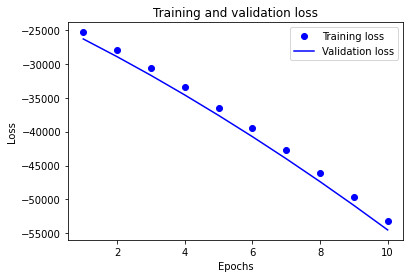

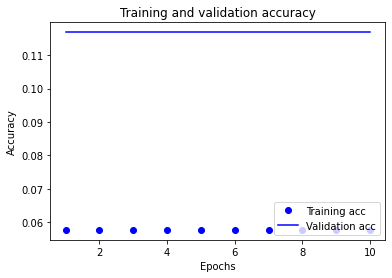

In [63]:
# test the model
loss, accuracy = ann.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

# show the result
history_dict = history.history
#history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# show loss
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()




## References

CSV reader example code:\
https://realpython.com/python-csv/

https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

https://www.geeksforgeeks.org/python-stemming-words-with-nltk/?ref=lbp

https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe

https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

https://towardsdatascience.com/heres-the-most-efficient-way-to-iterate-through-your-pandas-dataframe-4dad88ac92ee